# Setup

In [147]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from utils import reduce_mem_usage, create_new_columns
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [4]:
fpath = './features'
os.makedirs(fpath, exist_ok=True)

In [5]:
REF_DATE = pd.Timestamp('2019-01-01')

# Feature Engineering

## Transactions DataFrame

In [6]:
hist_trans = pd.read_csv('./data/historical_transactions.csv')
new_trans = pd.read_csv('./data/new_merchant_transactions.csv')

### Preprocessing

In [7]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
for df in [hist_trans, new_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])

purchase_amount>=0を満たすように正規化する  
(後にpurchase_amountと他の変数の積で新しい特徴量を作るため）  

In [9]:
for df in [hist_trans, new_trans]:
    purchase_amount_min = df['purchase_amount'].min()
    df['purchase_amount'] = df['purchase_amount'] - purchase_amount_min + 0.1

merchant_idの欠損値は最頻値で埋める

In [10]:
for df in [hist_trans, new_trans]:
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

#### fill nan of category_2 and 3

In [11]:
print(hist_trans['category_2'].value_counts(dropna=False) / len(hist_trans))

 1.0    0.521332
 3.0    0.134369
 5.0    0.127984
NaN     0.091125
 4.0    0.089929
 2.0    0.035261
Name: category_2, dtype: float64


In [12]:
print(hist_trans['category_3'].value_counts(dropna=False) / len(hist_trans))

A      0.529388
B      0.401119
C      0.063373
NaN    0.006120
Name: category_3, dtype: float64


category_2の欠損値は全体の9%を占めるので、nanカテゴリを作成する  
category_3の欠損値は全体の0.6%に過ぎないので、最頻値で埋める

In [13]:
for df in [hist_trans, new_trans]:
    df['category_2'].fillna(0.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)

#### encode categorical

LightGBM用にカテゴリカル変数を数値ラベルに変換する  
sklearnのLabelEncoderを使ってもよい

In [14]:
for df in [hist_trans, new_trans]:
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y': 1, 'N': 0})

In [15]:
for df in [hist_trans, new_trans]:
    df['category_2'] = df['category_2'].astype(int)

In [16]:
for df in [hist_trans, new_trans]:
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1, 'C': 2})

### observation date
https://www.kaggle.com/raddar/card-id-loyalty-different-points-in-time

card_id毎にhistorical_transactions.csvとnew_merchant_transactions.csvの境界日が異なる  
境界日observation_dateを算出する

In [17]:
last_hist_trans = hist_trans.groupby('card_id').agg({'month_lag' : 'max', 'purchase_date' : 'max'}).reset_index()
last_hist_trans.columns = ['card_id', 'hist_month_lag', 'hist_purchase_date']
last_hist_trans['observation_date'] = \
    last_hist_trans.apply(lambda x: x['hist_purchase_date'] - pd.DateOffset(months=x['hist_month_lag']), axis=1)
last_hist_trans['observation_date'] = \
    last_hist_trans['observation_date'].dt.to_period('M').dt.to_timestamp() + pd.DateOffset(months=1)

In [18]:
last_hist_trans.head()

,card_id,hist_month_lag,hist_purchase_date,observation_date
0,C_ID_00007093c1,0,2018-02-27 05:14:57,2018-03-01
1,C_ID_0001238066,0,2018-02-27 16:18:59,2018-03-01
2,C_ID_0001506ef0,0,2018-02-17 12:33:56,2018-03-01
3,C_ID_0001793786,0,2017-10-31 20:20:18,2017-11-01
4,C_ID_000183fdda,0,2018-02-25 20:57:08,2018-03-01


In [19]:
last_hist_trans = reduce_mem_usage(last_hist_trans.loc[:, ['card_id', 'observation_date']])

Memory usage after optimization is: 4.97 MB
Decreased by 0.0%


In [20]:
last_hist_trans.head()

,card_id,observation_date
0,C_ID_00007093c1,2018-03-01
1,C_ID_0001238066,2018-03-01
2,C_ID_0001506ef0,2018-03-01
3,C_ID_0001793786,2017-11-01
4,C_ID_000183fdda,2018-03-01


In [21]:
last_hist_trans.to_csv(os.path.join(fpath, 'observation_date.csv'), index=False)

In [22]:
del last_hist_trans; gc.collect()

49

### future amount
observation_date以降で分割払いが残っている購入の統計量を作る  
"LoyaltyScore=log((observation_dateから2ヶ月間の新規購買を除く購買)/(observation_date前の2ヶ月間の購買))"という仮説に基づく  
card_idに対する欠損が多くあまり精度向上に貢献しなかった  

In [23]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37


分割回数"installments"には-1と999の外れ値がある  
installments=0はおそらく一括払いを意味する  

In [24]:
usecols = ['card_id', 'purchase_amount', 'installments', 'month_lag', 'purchase_date']
hist_future = hist_trans.loc[~hist_trans['installments'].isin([-1, 0, 999]), usecols]

In [25]:
hist_future.head()

,card_id,purchase_amount,installments,month_lag,purchase_date
400,C_ID_5037ff576e,0.251648,1,-3,2017-09-07 20:57:19
401,C_ID_5037ff576e,2.036376,1,-4,2017-08-14 15:46:08
402,C_ID_5037ff576e,0.206838,1,-9,2017-03-05 14:57:51
403,C_ID_5037ff576e,0.194652,1,-4,2017-08-15 10:45:28
404,C_ID_5037ff576e,0.172698,1,-9,2017-03-26 20:00:31


In [26]:
hist_future['remain_payments'] = hist_future['installments'] + hist_future['month_lag']

In [27]:
hist_future = hist_future.loc[hist_future['remain_payments'] > 0, :]

In [28]:
hist_future['future_amount_by_purchase_amount'] = \
    hist_future['purchase_amount'] * hist_future['remain_payments'].apply(lambda x: min(2, x))

In [29]:
hist_future.head()

,card_id,purchase_amount,installments,month_lag,purchase_date,remain_payments,future_amount_by_purchase_amount
425,C_ID_5037ff576e,0.175133,1,0,2017-12-24 19:28:09,1,0.175133
452,C_ID_5037ff576e,1.091449,1,0,2017-12-15 14:02:29,1,1.091449
455,C_ID_5037ff576e,2.185995,1,0,2017-12-25 21:03:22,1,2.185995
479,C_ID_5037ff576e,0.175133,1,0,2017-12-02 20:21:59,1,0.175133
487,C_ID_5037ff576e,0.379493,1,0,2017-12-17 06:27:56,1,0.379493


In [30]:
aggs = {
    'future_amount_by_purchase_amount': ['count', 'sum', 'max'],
}

In [31]:
new_columns = create_new_columns('hist', aggs)
hist_future_gdf = hist_future.groupby('card_id').agg(aggs)
hist_future_gdf.columns = new_columns
hist_future_gdf.reset_index(drop=False, inplace=True)

In [32]:
hist_future_gdf.head()

,card_id,hist_future_amount_by_purchase_amount_count,hist_future_amount_by_purchase_amount_sum,hist_future_amount_by_purchase_amount_max
0,C_ID_00007093c1,15,8.551078,1.783794
1,C_ID_0001238066,39,18.998382,3.230006
2,C_ID_0001506ef0,1,0.138318,0.138318
3,C_ID_000183fdda,43,48.633050,7.223392
4,C_ID_00024e244b,1,0.166763,0.166763


In [33]:
hist_future_gdf = reduce_mem_usage(hist_future_gdf)

Memory usage after optimization is: 3.14 MB
Decreased by 43.7%


In [34]:
hist_future_gdf.to_csv(os.path.join(fpath, 'future.csv'), index=False)

In [35]:
del hist_future; gc.collect()
del hist_future_gdf; gc.collect()

0

### date

#### hist

In [36]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37


In [37]:
hist_trans['month'] = hist_trans['purchase_date'].dt.month
hist_trans['weekofyear'] = hist_trans['purchase_date'].dt.weekofyear
hist_trans['day'] = hist_trans['purchase_date'].dt.day
hist_trans['hour'] = hist_trans['purchase_date'].dt.hour

seasonal encodingは効果がなかったので不採用

In [38]:
aggs = {
    'card_id': ['size'],
    'purchase_date': ['max', 'min'],
    'month': ['nunique', 'mean', 'median', 'std'],
    'weekofyear': ['nunique', 'mean', 'median', 'std'],
    'day': ['nunique', 'mean', 'median', 'std'],
    'hour': ['nunique', 'mean', 'median', 'std'],
}

In [39]:
new_columns = create_new_columns('hist_date', aggs)
hist_date = hist_trans.groupby('card_id').agg(aggs)
hist_date.columns = new_columns
hist_date.reset_index(drop=False, inplace=True)

In [40]:
hist_date.head()

,card_id,hist_date_card_id_size,hist_date_purchase_date_max,hist_date_purchase_date_min,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std
0,C_ID_00007093c1,149,2018-02-27 05:14:57,2017-02-14 14:00:43,12,6.375839,6.0,3.303308,39,25.550336,26.0,14.336419,28,13.248322,11.0,9.082137,18,14.416107,15.0,4.226846
1,C_ID_0001238066,123,2018-02-27 16:18:59,2017-09-28 22:25:14,6,7.308943,10.0,4.895850,23,29.967480,43.0,21.327630,30,16.138211,18.0,8.524146,20,14.739837,16.0,5.862967
2,C_ID_0001506ef0,66,2018-02-17 12:33:56,2017-01-14 16:16:01,11,6.803030,7.0,4.524190,24,27.090909,27.0,19.625515,25,12.000000,9.5,7.619812,15,12.606061,12.0,3.156818
3,C_ID_0001793786,216,2017-10-31 20:20:18,2017-01-21 10:15:21,10,6.671296,7.0,2.306373,33,27.134259,29.5,10.160825,31,16.115741,15.5,8.338788,21,15.606481,15.0,4.393203
4,C_ID_000183fdda,144,2018-02-25 20:57:08,2017-08-07 09:49:14,7,6.881944,9.0,4.439959,27,27.881944,37.0,19.435206,30,14.034722,12.0,9.176142,19,16.465278,18.0,5.534271


In [41]:
prefix = 'hist_date_purchase_date_'

In [42]:
hist_date[prefix+'diff'] = (hist_date[prefix+'max'] - hist_date[prefix+'min']).dt.days
hist_date[prefix+'avg'] = hist_date[prefix+'diff'] / hist_date['hist_date_card_id_size']

In [43]:
hist_date.head()

,card_id,hist_date_card_id_size,hist_date_purchase_date_max,hist_date_purchase_date_min,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std,hist_date_purchase_date_diff,hist_date_purchase_date_avg
0,C_ID_00007093c1,149,2018-02-27 05:14:57,2017-02-14 14:00:43,12,6.375839,6.0,3.303308,39,25.550336,26.0,14.336419,28,13.248322,11.0,9.082137,18,14.416107,15.0,4.226846,377,2.530201
1,C_ID_0001238066,123,2018-02-27 16:18:59,2017-09-28 22:25:14,6,7.308943,10.0,4.895850,23,29.967480,43.0,21.327630,30,16.138211,18.0,8.524146,20,14.739837,16.0,5.862967,151,1.227642
2,C_ID_0001506ef0,66,2018-02-17 12:33:56,2017-01-14 16:16:01,11,6.803030,7.0,4.524190,24,27.090909,27.0,19.625515,25,12.000000,9.5,7.619812,15,12.606061,12.0,3.156818,398,6.030303
3,C_ID_0001793786,216,2017-10-31 20:20:18,2017-01-21 10:15:21,10,6.671296,7.0,2.306373,33,27.134259,29.5,10.160825,31,16.115741,15.5,8.338788,21,15.606481,15.0,4.393203,283,1.310185
4,C_ID_000183fdda,144,2018-02-25 20:57:08,2017-08-07 09:49:14,7,6.881944,9.0,4.439959,27,27.881944,37.0,19.435206,30,14.034722,12.0,9.176142,19,16.465278,18.0,5.534271,202,1.402778


#### new

In [44]:
new_trans['month'] = new_trans['purchase_date'].dt.month
new_trans['weekofyear'] = new_trans['purchase_date'].dt.weekofyear
new_trans['day'] = new_trans['purchase_date'].dt.day
new_trans['dayofweek'] = new_trans['purchase_date'].dt.dayofweek
new_trans['hour'] = new_trans['purchase_date'].dt.hour

In [45]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,dayofweek,hour
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,0.2894,2018-03-11 14:57:36,1,9,19,3,10,11,6,14
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,0.2777,2018-03-19 18:53:37,1,9,19,3,12,19,0,18
2,1,C_ID_415bb3a509,330,0,1,1,507,M_ID_ad5237ef6b,2,0.2957,2018-04-26 14:08:44,1,9,14,4,17,26,3,14
3,1,C_ID_415bb3a509,-1,1,1,1,661,M_ID_9e84cda3b1,1,0.1750,2018-03-07 09:43:21,0,-1,8,3,10,7,2,9
4,1,C_ID_ef55cf8d4b,-1,1,1,1,166,M_ID_3c86fa3831,1,0.1873,2018-03-22 21:07:53,0,-1,29,3,12,22,3,21


In [46]:
aggs = {
    'card_id': ['size'],
    'purchase_date': ['max', 'min'],
    'month': ['mean'],
    'weekofyear': ['mean', 'median', 'max', 'min', 'std'],
    'day': ['mean', 'median', 'std'],
    'dayofweek': ['mean', 'median', 'std'],
    'hour': ['mean', 'median', 'std'],
}

In [47]:
new_columns = create_new_columns('new_date', aggs)
new_date = new_trans.groupby('card_id').agg(aggs)
new_date.columns = new_columns
new_date.reset_index(drop=False, inplace=True)

In [48]:
prefix = 'new_date_purchase_date_'

In [49]:
new_date[prefix+'diff'] = (new_date[prefix+'max'] - new_date[prefix+'min']).dt.days
new_date[prefix+'avg'] = new_date[prefix+'diff'] / new_date['new_date_card_id_size']

In [50]:
new_date.head()

,card_id,new_date_card_id_size,new_date_purchase_date_max,new_date_purchase_date_min,new_date_month_mean,new_date_weekofyear_mean,new_date_weekofyear_median,new_date_weekofyear_max,new_date_weekofyear_min,new_date_weekofyear_std,new_date_day_mean,new_date_day_median,new_date_day_std,new_date_dayofweek_mean,new_date_dayofweek_median,new_date_dayofweek_std,new_date_hour_mean,new_date_hour_median,new_date_hour_std,new_date_purchase_date_diff,new_date_purchase_date_avg
0,C_ID_00007093c1,2,2018-04-09 16:23:59,2018-04-03 11:13:35,4.000000,14.500000,14.5,15,14,0.707107,6.000000,6.0,4.242641,0.500000,0.5,0.707107,13.500000,13.5,3.535534,6,3.000000
1,C_ID_0001238066,26,2018-04-30 19:57:30,2018-03-01 16:48:27,3.346154,12.846154,12.0,18,9,2.633512,18.230769,19.5,9.039061,4.038462,4.0,1.799573,15.192308,16.5,5.959995,60,2.307692
2,C_ID_0001506ef0,2,2018-03-22 09:14:30,2018-03-16 22:21:58,3.000000,11.500000,11.5,12,11,0.707107,19.000000,19.0,4.242641,3.500000,3.5,0.707107,15.500000,15.5,9.192388,5,2.500000
3,C_ID_0001793786,31,2017-12-31 17:35:56,2017-11-15 15:44:20,11.322581,48.387097,48.0,52,46,2.108355,23.612903,26.0,6.075511,3.580645,4.0,2.349102,11.419355,14.0,7.706163,46,1.483871
4,C_ID_000183fdda,11,2018-04-30 14:59:53,2018-03-02 12:26:26,3.272727,11.818182,10.0,18,9,3.250175,11.727273,8.0,10.564951,2.454545,3.0,1.967925,15.454545,14.0,3.387141,59,5.363636


#### save

In [51]:
del hist_date['hist_date_card_id_size']; gc.collect()
del new_date['new_date_card_id_size']; gc.collect()

0

In [52]:
hist_date = reduce_mem_usage(hist_date)
new_date = reduce_mem_usage(new_date)

Memory usage after optimization is: 17.39 MB
Decreased by 66.7%
Memory usage after optimization is: 15.21 MB
Decreased by 65.6%


In [53]:
hist_date.to_csv(os.path.join(fpath, 'hist_date.csv'), index=False)
new_date.to_csv(os.path.join(fpath, 'new_date.csv'), index=False)

In [54]:
del hist_date; gc.collect()
del new_date; gc.collect()

7

### amount

In [55]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,hour
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37,6,25,25,15
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16,7,28,15,12
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37,8,32,9,22
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34,9,35,2,10
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37,3,10,10,1


過去の購買に重きを置いた総購買の重み付き和"purchase_amount_distant"  
直近の購買に重きを置いた総購買の重み付き和"purchase_amount_close"  

In [56]:
for df in [hist_trans, new_trans]:
    df['purchase_amount_distant'] = df['purchase_amount'] * (np.abs(df['month_lag']) + 1)
    df['purchase_amount_close'] = df['purchase_amount'] / (np.abs(df['month_lag']) + 1)

In [57]:
aggs = {
    'purchase_amount': ['mean', 'median', 'max', 'min', 'std', 'skew'],
    'purchase_amount_distant': ['sum'],
    'purchase_amount_close': ['sum'],
}

In [58]:
new_columns = create_new_columns('hist_amount', aggs)
hist_amount = hist_trans.groupby('card_id').agg(aggs)
hist_amount.columns = new_columns
hist_amount.reset_index(drop=False, inplace=True)

In [59]:
new_columns = create_new_columns('new_amount', aggs)
new_amount = new_trans.groupby('card_id').agg(aggs)
new_amount.columns = new_columns
new_amount.reset_index(drop=False, inplace=True)

In [60]:
hist_amount.head()

,card_id,hist_amount_purchase_amount_mean,hist_amount_purchase_amount_median,hist_amount_purchase_amount_max,hist_amount_purchase_amount_min,hist_amount_purchase_amount_std,hist_amount_purchase_amount_skew,hist_amount_purchase_amount_distant_sum,hist_amount_purchase_amount_close_sum
0,C_ID_00007093c1,0.331169,0.259281,2.353977,0.118032,0.298141,3.966544,347.771199,11.702095
1,C_ID_0001238066,0.257906,0.198724,1.615003,0.112021,0.190235,4.057432,87.125476,14.779831
2,C_ID_0001506ef0,0.322637,0.143201,2.340453,0.106416,0.472284,2.692444,104.285275,7.606740
3,C_ID_0001793786,0.676602,0.358997,5.401053,0.101503,0.836046,3.001742,654.881651,47.102939
4,C_ID_000183fdda,0.368867,0.185614,3.611696,0.109016,0.524948,3.840939,176.891584,22.911846


In [61]:
hist_amount = reduce_mem_usage(hist_amount)
new_amount = reduce_mem_usage(new_amount)

Memory usage after optimization is: 10.56 MB
Decreased by 52.8%
Memory usage after optimization is: 6.64 MB
Decreased by 66.7%


In [62]:
hist_amount.to_csv(os.path.join(fpath, 'hist_amount.csv'), index=False)
new_amount.to_csv(os.path.join(fpath, 'new_amount.csv'), index=False)

In [63]:
del hist_amount; gc.collect()
del new_amount; gc.collect()

7

### lagged stats

#### hist by round_month_lag

LoyaltyScoreの仮説から、期間を2ヶ月毎に区切り集計を行うことに意味があると考えた  
month_lagを用いて2ヶ月の期間に区切り、各期間に置ける購買を集計した  

In [64]:
hist_trans['round_month_lag'] = (hist_trans['month_lag'] + 1) // 2

In [65]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,hour,purchase_amount_distant,purchase_amount_close,round_month_lag
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37,6,25,25,15,1.292192,0.015953,-4
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16,7,28,15,12,0.910234,0.014222,-3
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37,8,32,9,22,0.885653,0.018075,-3
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34,9,35,2,10,0.669332,0.018593,-2
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37,3,10,10,1,1.488509,0.010337,-5


In [66]:
aggs = {
    'purchase_amount': ['sum', 'mean', 'median', 'max', 'std'],
}

In [67]:
hist_lagged = hist_trans.groupby(['card_id', 'round_month_lag']).agg(aggs)
hist_lagged = hist_lagged.unstack()
hist_lagged.columns = ['hist_lagged_'+'_'.join([str(col) for col in cols]) for cols in hist_lagged.columns.values]
hist_lagged.reset_index(inplace=True)

In [68]:
hist_lagged.head()

,card_id,hist_lagged_purchase_amount_sum_-6,hist_lagged_purchase_amount_sum_-5,hist_lagged_purchase_amount_sum_-4,hist_lagged_purchase_amount_sum_-3,hist_lagged_purchase_amount_sum_-2,hist_lagged_purchase_amount_sum_-1,hist_lagged_purchase_amount_sum_0,hist_lagged_purchase_amount_mean_-6,hist_lagged_purchase_amount_mean_-5,hist_lagged_purchase_amount_mean_-4,hist_lagged_purchase_amount_mean_-3,hist_lagged_purchase_amount_mean_-2,hist_lagged_purchase_amount_mean_-1,hist_lagged_purchase_amount_mean_0,hist_lagged_purchase_amount_median_-6,hist_lagged_purchase_amount_median_-5,hist_lagged_purchase_amount_median_-4,hist_lagged_purchase_amount_median_-3,hist_lagged_purchase_amount_median_-2,hist_lagged_purchase_amount_median_-1,hist_lagged_purchase_amount_median_0,hist_lagged_purchase_amount_max_-6,hist_lagged_purchase_amount_max_-5,hist_lagged_purchase_amount_max_-4,hist_lagged_purchase_amount_max_-3,hist_lagged_purchase_amount_max_-2,hist_lagged_purchase_amount_max_-1,hist_lagged_purchase_amount_max_0,hist_lagged_purchase_amount_std_-6,hist_lagged_purchase_amount_std_-5,hist_lagged_purchase_amount_std_-4,hist_lagged_purchase_amount_std_-3,hist_lagged_purchase_amount_std_-2,hist_lagged_purchase_amount_std_-1,hist_lagged_purchase_amount_std_0
0,C_ID_00007093c1,2.053217,6.410654,11.266401,11.459758,5.262644,6.195961,6.695587,0.513304,0.291393,0.388497,0.358117,0.239211,0.344220,0.304345,0.447413,0.271302,0.265292,0.243503,0.240423,0.281340,0.306111,0.884083,0.851326,1.154861,2.353977,0.430583,0.891897,0.851326,0.266149,0.167761,0.295519,0.503440,0.090112,0.222408,0.161430
1,C_ID_0001238066,NaN,NaN,NaN,NaN,2.908077,14.944892,13.869489,NaN,NaN,NaN,NaN,0.223698,0.249082,0.277390,NaN,NaN,NaN,NaN,0.196215,0.199250,0.193149,NaN,NaN,NaN,NaN,0.438142,0.779198,1.615003,NaN,NaN,NaN,NaN,0.107130,0.132784,0.255481
2,C_ID_0001506ef0,1.053844,1.230555,0.482451,3.204698,3.026317,6.509930,5.786240,0.150549,0.153819,0.120613,0.801175,0.605263,0.260397,0.445095,0.130684,0.148708,0.115477,0.743886,0.168731,0.141323,0.147333,0.218710,0.187454,0.145080,1.605657,1.377254,1.377254,2.340453,0.036884,0.019947,0.018413,0.796213,0.638593,0.322859,0.721454
3,C_ID_0001793786,NaN,NaN,8.337028,27.399652,30.880174,41.845409,37.683809,NaN,NaN,1.042128,0.595645,0.753175,0.664213,0.649721,NaN,NaN,0.612209,0.293842,0.358456,0.425504,0.331408,NaN,NaN,2.317282,3.541342,5.401053,2.580577,5.277775,NaN,NaN,0.917892,0.766067,1.030752,0.655024,0.910089
4,C_ID_000183fdda,NaN,NaN,NaN,4.854607,10.712288,13.343207,24.206684,NaN,NaN,NaN,0.809101,0.227921,0.381234,0.432262,NaN,NaN,NaN,0.844263,0.175133,0.187154,0.175133,NaN,NaN,NaN,1.181007,0.913265,2.752029,3.611696,NaN,NaN,NaN,0.409220,0.165412,0.535450,0.677369


In [69]:
hist_lagged = reduce_mem_usage(hist_lagged)

Memory usage after optimization is: 34.15 MB
Decreased by 61.8%


In [70]:
hist_lagged.to_csv(os.path.join(fpath, 'hist_lagged.csv'), index=False)

In [71]:
del hist_lagged; gc.collect()

7

#### new by month_lag

new_merchantデータは各card_id毎に2ヶ月分のデータしかないので、month_lagを丸めず集計する  

In [72]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,dayofweek,hour,purchase_amount_distant,purchase_amount_close
0,1,C_ID_415bb3a509,107,0,1,1,307,M_ID_b0c793002c,1,0.2894,2018-03-11 14:57:36,1,9,19,3,10,11,6,14,0.5788,0.144700
1,1,C_ID_415bb3a509,140,0,1,1,307,M_ID_88920c89e8,1,0.2777,2018-03-19 18:53:37,1,9,19,3,12,19,0,18,0.5554,0.138850
2,1,C_ID_415bb3a509,330,0,1,1,507,M_ID_ad5237ef6b,2,0.2957,2018-04-26 14:08:44,1,9,14,4,17,26,3,14,0.8871,0.098567
3,1,C_ID_415bb3a509,-1,1,1,1,661,M_ID_9e84cda3b1,1,0.1750,2018-03-07 09:43:21,0,-1,8,3,10,7,2,9,0.3500,0.087500
4,1,C_ID_ef55cf8d4b,-1,1,1,1,166,M_ID_3c86fa3831,1,0.1873,2018-03-22 21:07:53,0,-1,29,3,12,22,3,21,0.3746,0.093650


In [73]:
aggs = {
    'purchase_amount': ['sum', 'mean', 'median', 'max', 'std'],
}

In [74]:
new_lagged = new_trans.groupby(['card_id', 'month_lag']).agg(aggs)
new_lagged = new_lagged.unstack()
new_lagged.columns = ['new_lagged_'+'_'.join([str(col) for col in cols]) for cols in new_lagged.columns.values]
new_lagged.reset_index(inplace=True)

In [75]:
new_lagged['new_lagged_purchase_amount_sum_ratio'] = \
    new_lagged['new_lagged_purchase_amount_sum_1'] / new_lagged['new_lagged_purchase_amount_sum_2']

In [76]:
new_lagged.head()

,card_id,new_lagged_purchase_amount_sum_1,new_lagged_purchase_amount_sum_2,new_lagged_purchase_amount_mean_1,new_lagged_purchase_amount_mean_2,new_lagged_purchase_amount_median_1,new_lagged_purchase_amount_median_2,new_lagged_purchase_amount_max_1,new_lagged_purchase_amount_max_2,new_lagged_purchase_amount_std_1,new_lagged_purchase_amount_std_2,new_lagged_purchase_amount_sum_ratio
0,C_ID_00007093c1,NaN,0.36530,NaN,0.182650,NaN,0.18265,NaN,0.19030,NaN,0.010819,NaN
1,C_ID_0001238066,4.643900,2.52750,0.273171,0.280833,0.17070,0.28000,0.7687,0.47570,0.202207,0.110265,1.837349
2,C_ID_0001506ef0,0.246700,NaN,0.123350,NaN,0.12335,NaN,0.1317,NaN,0.011809,NaN,NaN
3,C_ID_0001793786,19.462014,6.56450,0.926763,0.656450,0.48540,0.42200,3.9770,2.35400,1.048742,0.701214,2.964737
4,C_ID_000183fdda,1.665200,1.06133,0.208150,0.353777,0.19345,0.16800,0.3873,0.73933,0.096385,0.333972,1.568975


In [77]:
new_lagged = reduce_mem_usage(new_lagged)

Memory usage after optimization is: 8.30 MB
Decreased by 68.7%


In [78]:
new_lagged.to_csv(os.path.join(fpath, 'new_lagged.csv'), index=False)

In [79]:
del new_lagged; gc.collect()

0

### categorycal aggregation

カテゴリカル変数で条件付けた時の集計

In [80]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,hour,purchase_amount_distant,purchase_amount_close,round_month_lag
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37,6,25,25,15,1.292192,0.015953,-4
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16,7,28,15,12,0.910234,0.014222,-3
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37,8,32,9,22,0.885653,0.018075,-3
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34,9,35,2,10,0.669332,0.018593,-2
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37,3,10,10,1,1.488509,0.010337,-5


#### authorized_flag (only hist)

In [81]:
aggs = {
    'authorized_flag': ['count'],
    'purchase_amount': ['sum', 'mean', 'median', 'max', 'std'],
    'merchant_id': ['nunique'],
}

In [82]:
hist_gdf = hist_trans.groupby(['card_id', 'authorized_flag']).agg(aggs)
hist_gdf = hist_gdf.unstack()
hist_gdf.columns = ['hist_authorized_flag_agg_'+'_'.join([str(col) for col in cols]) for cols in hist_gdf.columns.values]
hist_gdf.reset_index(inplace=True)

In [83]:
hist_gdf.head()

,card_id,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1
0,C_ID_00007093c1,35.0,114.0,15.239808,34.104414,0.435423,0.299162,0.277689,0.250265,2.353977,2.053447,0.430059,0.237426,11.0,28.0
1,C_ID_0001238066,3.0,120.0,0.750795,30.971663,0.250265,0.258097,0.250265,0.196786,0.250265,1.615003,0.000000,0.192614,2.0,65.0
2,C_ID_0001506ef0,4.0,62.0,0.481849,20.812186,0.120462,0.335680,0.118558,0.146687,0.138318,2.340453,0.016203,0.484575,4.0,28.0
3,C_ID_0001793786,27.0,189.0,11.041172,135.104900,0.408932,0.714841,0.280288,0.399028,2.083500,5.401053,0.498150,0.867916,17.0,114.0
4,C_ID_000183fdda,7.0,137.0,4.986974,48.129812,0.712425,0.351312,0.507519,0.176214,1.181007,3.611696,0.452741,0.523760,4.0,71.0


In [84]:
prefix = 'hist_authorized_flag_agg_authorized_flag_count_'
hist_gdf[prefix+'ratio'] = hist_gdf[prefix+'0'] / hist_gdf[prefix+'1']

In [85]:
prefix = 'hist_authorized_flag_agg_purchase_amount_sum_'
hist_gdf[prefix+'ratio'] = hist_gdf[prefix+'0'] / hist_gdf[prefix+'1']

In [86]:
hist_gdf.head()

,card_id,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1,hist_authorized_flag_agg_authorized_flag_count_ratio,hist_authorized_flag_agg_purchase_amount_sum_ratio
0,C_ID_00007093c1,35.0,114.0,15.239808,34.104414,0.435423,0.299162,0.277689,0.250265,2.353977,2.053447,0.430059,0.237426,11.0,28.0,0.307018,0.446857
1,C_ID_0001238066,3.0,120.0,0.750795,30.971663,0.250265,0.258097,0.250265,0.196786,0.250265,1.615003,0.000000,0.192614,2.0,65.0,0.025000,0.024241
2,C_ID_0001506ef0,4.0,62.0,0.481849,20.812186,0.120462,0.335680,0.118558,0.146687,0.138318,2.340453,0.016203,0.484575,4.0,28.0,0.064516,0.023152
3,C_ID_0001793786,27.0,189.0,11.041172,135.104900,0.408932,0.714841,0.280288,0.399028,2.083500,5.401053,0.498150,0.867916,17.0,114.0,0.142857,0.081723
4,C_ID_000183fdda,7.0,137.0,4.986974,48.129812,0.712425,0.351312,0.507519,0.176214,1.181007,3.611696,0.452741,0.523760,4.0,71.0,0.051095,0.103615


In [87]:
hist_gdf = reduce_mem_usage(hist_gdf)

Memory usage after optimization is: 16.14 MB
Decreased by 61.8%


In [88]:
hist_gdf.to_csv(os.path.join(fpath, 'hist_authorized.csv'), index=False)

#### category_1

In [89]:
aggs = {
    'category_1': ['count'],
    'purchase_amount': ['sum', 'mean', 'median', 'max', 'std'],
}

In [90]:
hist_gdf = hist_trans.groupby(['card_id', 'category_1']).agg(aggs)
hist_gdf = hist_gdf.unstack()
hist_gdf.columns = ['hist_category_1_agg_'+'_'.join([str(col) for col in cols]) for cols in hist_gdf.columns.values]
hist_gdf.reset_index(inplace=True)

In [91]:
new_gdf = new_trans.groupby(['card_id', 'category_1']).agg(aggs)
new_gdf = new_gdf.unstack()
new_gdf.columns = ['new_category_1_agg_'+'_'.join([str(col) for col in cols]) for cols in new_gdf.columns.values]
new_gdf.reset_index(inplace=True)

In [92]:
hist_gdf.head()

,card_id,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1
0,C_ID_00007093c1,121.0,28.0,45.669844,3.674378,0.377437,0.131228,0.280318,0.125545,2.353977,0.174967,0.313233,0.011051
1,C_ID_0001238066,121.0,2.0,29.707812,2.014647,0.245519,1.007323,0.197357,1.007323,1.091750,1.615003,0.145337,0.859389
2,C_ID_0001506ef0,66.0,NaN,21.294036,NaN,0.322637,NaN,0.143201,NaN,2.340453,NaN,0.472284,NaN
3,C_ID_0001793786,214.0,2.0,145.943067,0.203005,0.681977,0.101503,0.360838,0.101503,5.401053,0.101503,0.838094,0.000000
4,C_ID_000183fdda,140.0,4.0,46.849128,6.267658,0.334637,1.566914,0.176553,1.572598,3.611696,2.752029,0.469015,0.987361


In [93]:
new_gdf.head()

,card_id,new_category_1_agg_category_1_count_0,new_category_1_agg_category_1_count_1,new_category_1_agg_purchase_amount_sum_0,new_category_1_agg_purchase_amount_sum_1,new_category_1_agg_purchase_amount_mean_0,new_category_1_agg_purchase_amount_mean_1,new_category_1_agg_purchase_amount_median_0,new_category_1_agg_purchase_amount_median_1,new_category_1_agg_purchase_amount_max_0,new_category_1_agg_purchase_amount_max_1,new_category_1_agg_purchase_amount_std_0,new_category_1_agg_purchase_amount_std_1
0,C_ID_00007093c1,2.0,NaN,0.365300,NaN,0.182650,NaN,0.18265,NaN,0.19030,NaN,0.010819,NaN
1,C_ID_0001238066,24.0,2.0,6.777700,0.3937,0.282404,0.19685,0.19785,0.19685,0.76870,0.2874,0.177164,0.128057
2,C_ID_0001506ef0,2.0,NaN,0.246700,NaN,0.123350,NaN,0.12335,NaN,0.13170,NaN,0.011809,NaN
3,C_ID_0001793786,31.0,NaN,26.026514,NaN,0.839565,NaN,0.47420,NaN,3.97700,NaN,0.947233,NaN
4,C_ID_000183fdda,11.0,NaN,2.726530,NaN,0.247866,NaN,0.18150,NaN,0.73933,NaN,0.182860,NaN


In [94]:
prefix = 'hist_category_1_agg_category_1_count_'
hist_gdf[prefix+'ratio'] = hist_gdf[prefix+'0'] / hist_gdf[prefix+'1']

In [95]:
prefix = 'new_category_1_agg_category_1_count_'
new_gdf[prefix+'ratio'] = new_gdf[prefix+'0'] / new_gdf[prefix+'1']

In [96]:
prefix = 'hist_category_1_agg_purchase_amount_sum_'
hist_gdf[prefix+'ratio'] = hist_gdf[prefix+'0'] / hist_gdf[prefix+'1']

In [97]:
prefix = 'new_category_1_agg_purchase_amount_sum_'
new_gdf[prefix+'ratio'] = new_gdf[prefix+'0'] / new_gdf[prefix+'1']

In [98]:
hist_gdf.head()

,card_id,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1,hist_category_1_agg_category_1_count_ratio,hist_category_1_agg_purchase_amount_sum_ratio
0,C_ID_00007093c1,121.0,28.0,45.669844,3.674378,0.377437,0.131228,0.280318,0.125545,2.353977,0.174967,0.313233,0.011051,4.321429,12.429271
1,C_ID_0001238066,121.0,2.0,29.707812,2.014647,0.245519,1.007323,0.197357,1.007323,1.091750,1.615003,0.145337,0.859389,60.500000,14.745917
2,C_ID_0001506ef0,66.0,NaN,21.294036,NaN,0.322637,NaN,0.143201,NaN,2.340453,NaN,0.472284,NaN,NaN,NaN
3,C_ID_0001793786,214.0,2.0,145.943067,0.203005,0.681977,0.101503,0.360838,0.101503,5.401053,0.101503,0.838094,0.000000,107.000000,718.912523
4,C_ID_000183fdda,140.0,4.0,46.849128,6.267658,0.334637,1.566914,0.176553,1.572598,3.611696,2.752029,0.469015,0.987361,35.000000,7.474743


In [99]:
new_gdf.head()

,card_id,new_category_1_agg_category_1_count_0,new_category_1_agg_category_1_count_1,new_category_1_agg_purchase_amount_sum_0,new_category_1_agg_purchase_amount_sum_1,new_category_1_agg_purchase_amount_mean_0,new_category_1_agg_purchase_amount_mean_1,new_category_1_agg_purchase_amount_median_0,new_category_1_agg_purchase_amount_median_1,new_category_1_agg_purchase_amount_max_0,new_category_1_agg_purchase_amount_max_1,new_category_1_agg_purchase_amount_std_0,new_category_1_agg_purchase_amount_std_1,new_category_1_agg_category_1_count_ratio,new_category_1_agg_purchase_amount_sum_ratio
0,C_ID_00007093c1,2.0,NaN,0.365300,NaN,0.182650,NaN,0.18265,NaN,0.19030,NaN,0.010819,NaN,NaN,NaN
1,C_ID_0001238066,24.0,2.0,6.777700,0.3937,0.282404,0.19685,0.19785,0.19685,0.76870,0.2874,0.177164,0.128057,12.0,17.215392
2,C_ID_0001506ef0,2.0,NaN,0.246700,NaN,0.123350,NaN,0.12335,NaN,0.13170,NaN,0.011809,NaN,NaN,NaN
3,C_ID_0001793786,31.0,NaN,26.026514,NaN,0.839565,NaN,0.47420,NaN,3.97700,NaN,0.947233,NaN,NaN,NaN
4,C_ID_000183fdda,11.0,NaN,2.726530,NaN,0.247866,NaN,0.18150,NaN,0.73933,NaN,0.182860,NaN,NaN,NaN


In [100]:
hist_gdf = reduce_mem_usage(hist_gdf)
new_gdf = reduce_mem_usage(new_gdf)

Memory usage after optimization is: 14.28 MB
Decreased by 61.7%
Memory usage after optimization is: 9.96 MB
Decreased by 70.0%


In [101]:
hist_gdf.to_csv(os.path.join(fpath, 'hist_category_1.csv'), index=False)
new_gdf.to_csv(os.path.join(fpath, 'new_category_1.csv'), index=False)

#### month

In [102]:
hist_trans['month'] = hist_trans['purchase_date'].dt.month

In [103]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,hour,purchase_amount_distant,purchase_amount_close,round_month_lag
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37,6,25,25,15,1.292192,0.015953,-4
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16,7,28,15,12,0.910234,0.014222,-3
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37,8,32,9,22,0.885653,0.018075,-3
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34,9,35,2,10,0.669332,0.018593,-2
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37,3,10,10,1,1.488509,0.010337,-5


In [104]:
aggs = {
    'purchase_amount': ['sum', 'mean', 'median', 'max', 'std'],
}

In [105]:
hist_gdf = hist_trans.groupby(['card_id', 'month']).agg(aggs)
hist_gdf = hist_gdf.unstack()
hist_gdf.columns = ['hist_month_agg_'+'_'.join([str(col) for col in cols]) for cols in hist_gdf.columns.values]
hist_gdf.reset_index(inplace=True)

In [106]:
hist_gdf.head()

,card_id,hist_month_agg_purchase_amount_sum_1,hist_month_agg_purchase_amount_sum_2,hist_month_agg_purchase_amount_sum_3,hist_month_agg_purchase_amount_sum_4,hist_month_agg_purchase_amount_sum_5,hist_month_agg_purchase_amount_sum_6,hist_month_agg_purchase_amount_sum_7,hist_month_agg_purchase_amount_sum_8,hist_month_agg_purchase_amount_sum_9,hist_month_agg_purchase_amount_sum_10,hist_month_agg_purchase_amount_sum_11,hist_month_agg_purchase_amount_sum_12,hist_month_agg_purchase_amount_mean_1,hist_month_agg_purchase_amount_mean_2,hist_month_agg_purchase_amount_mean_3,hist_month_agg_purchase_amount_mean_4,hist_month_agg_purchase_amount_mean_5,hist_month_agg_purchase_amount_mean_6,hist_month_agg_purchase_amount_mean_7,hist_month_agg_purchase_amount_mean_8,hist_month_agg_purchase_amount_mean_9,hist_month_agg_purchase_amount_mean_10,hist_month_agg_purchase_amount_mean_11,hist_month_agg_purchase_amount_mean_12,hist_month_agg_purchase_amount_median_1,hist_month_agg_purchase_amount_median_2,hist_month_agg_purchase_amount_median_3,hist_month_agg_purchase_amount_median_4,hist_month_agg_purchase_amount_median_5,hist_month_agg_purchase_amount_median_6,hist_month_agg_purchase_amount_median_7,hist_month_agg_purchase_amount_median_8,hist_month_agg_purchase_amount_median_9,hist_month_agg_purchase_amount_median_10,hist_month_agg_purchase_amount_median_11,hist_month_agg_purchase_amount_median_12,hist_month_agg_purchase_amount_max_1,hist_month_agg_purchase_amount_max_2,hist_month_agg_purchase_amount_max_3,hist_month_agg_purchase_amount_max_4,hist_month_agg_purchase_amount_max_5,hist_month_agg_purchase_amount_max_6,hist_month_agg_purchase_amount_max_7,hist_month_agg_purchase_amount_max_8,hist_month_agg_purchase_amount_max_9,hist_month_agg_purchase_amount_max_10,hist_month_agg_purchase_amount_max_11,hist_month_agg_purchase_amount_max_12,hist_month_agg_purchase_amount_std_1,hist_month_agg_purchase_amount_std_2,hist_month_agg_purchase_amount_std_3,hist_month_agg_purchase_amount_std_4,hist_month_agg_purchase_amount_std_5,hist_month_agg_purchase_amount_std_6,hist_month_agg_purchase_amount_std_7,hist_month_agg_purchase_amount_std_8,hist_month_agg_purchase_amount_std_9,hist_month_agg_purchase_amount_std_10,hist_month_agg_purchase_amount_std_11,hist_month_agg_purchase_amount_std_12
0,C_ID_00007093c1,2.783031,5.965773,2.756449,3.654205,5.043830,6.222572,3.465152,7.994606,1.288246,3.974398,2.012868,4.183093,0.278303,0.372861,0.275645,0.304517,0.504383,0.327504,0.231010,0.470271,0.257649,0.233788,0.335478,0.348591,0.272805,0.345683,0.280318,0.212699,0.262286,0.272850,0.236741,0.250265,0.269905,0.220062,0.207627,0.289417,0.454626,0.884083,0.445610,0.851326,1.154861,0.851326,0.454626,2.353977,0.430583,0.331408,0.891897,0.701060,0.121181,0.219144,0.085455,0.217579,0.402503,0.208464,0.109076,0.672414,0.128857,0.079808,0.301480,0.187270
1,C_ID_0001238066,8.437710,5.431779,NaN,NaN,NaN,NaN,NaN,NaN,0.391032,2.517045,5.052181,9.892711,0.324527,0.226324,NaN,NaN,NaN,NaN,NaN,NaN,0.195516,0.228822,0.219660,0.267371,0.210445,0.185636,NaN,NaN,NaN,NaN,NaN,NaN,0.195516,0.196215,0.194667,0.250265,1.615003,0.579766,NaN,NaN,NaN,NaN,NaN,NaN,0.272895,0.438142,0.430583,0.779198,0.338234,0.097326,NaN,NaN,NaN,NaN,NaN,NaN,0.109430,0.111297,0.096319,0.149432
2,C_ID_0001506ef0,3.028205,3.811880,1.230555,NaN,0.145080,0.337371,1.728196,1.476502,1.357793,1.668525,2.336808,4.173122,0.336467,0.346535,0.153819,NaN,0.145080,0.112457,0.864098,0.738251,0.678896,0.556175,0.333830,0.231840,0.158603,0.138318,0.148708,NaN,0.145080,0.106416,0.864098,0.738251,0.678896,0.168731,0.146793,0.137897,1.752916,2.340453,0.187454,NaN,0.145080,0.124538,1.605657,1.365232,1.226988,1.377254,1.377254,1.226988,0.532326,0.661921,0.019947,NaN,NaN,0.010463,1.048722,0.886685,0.775119,0.711450,0.462839,0.261665
3,C_ID_0001793786,2.108112,6.228916,12.704457,14.695194,5.479337,25.400838,23.894396,17.951013,26.243628,11.440181,NaN,NaN,1.054056,1.038153,0.794029,0.489840,1.369834,0.686509,0.823945,0.527971,0.690622,0.572009,N

In [107]:
hist_gdf = reduce_mem_usage(hist_gdf)

Memory usage after optimization is: 56.50 MB
Decreased by 62.7%


In [108]:
hist_gdf.to_csv(os.path.join(fpath, 'hist_month.csv'), index=False)

### others

In [109]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month,weekofyear,day,hour,purchase_amount_distant,purchase_amount_close,round_month_lag
0,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-8,0.143577,2017-06-25 15:33:07,1,16,37,6,25,25,15,1.292192,0.015953,-4
1,1,C_ID_4e6213e9bc,88,0,0,0,367,M_ID_86ec983688,-7,0.113779,2017-07-15 12:10:45,1,16,16,7,28,15,12,0.910234,0.014222,-3
2,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_979ed661fc,-6,0.126522,2017-08-09 22:04:29,1,16,37,8,32,9,22,0.885653,0.018075,-3
3,1,C_ID_4e6213e9bc,88,0,0,0,560,M_ID_e6d5ae8ea6,-5,0.111555,2017-09-02 10:06:26,1,16,34,9,35,2,10,0.669332,0.018593,-2
4,1,C_ID_4e6213e9bc,88,0,0,0,80,M_ID_e020e9b302,-11,0.124042,2017-03-10 01:14:19,1,16,37,3,10,10,1,1.488509,0.010337,-5


In [110]:
aggs = {
    'authorized_flag': ['sum', 'mean'],
    'card_id': ['size'],
    'category_1': ['sum', 'mean'],
    'installments': ['mean', 'max', 'skew'],
}

In [111]:
new_columns = create_new_columns('hist_others', aggs)
hist_others = hist_trans.groupby('card_id').agg(aggs)
hist_others.columns = new_columns
hist_others.reset_index(drop=False, inplace=True)

In [112]:
new_columns = create_new_columns('new_others', aggs)
new_others = new_trans.groupby('card_id').agg(aggs)
new_others.columns = new_columns
new_others.reset_index(drop=False, inplace=True)

In [113]:
# new authorized flag is all 1
del new_others['new_others_authorized_flag_sum']; gc.collect()
del new_others['new_others_authorized_flag_mean']; gc.collect()

7

In [114]:
hist_others.head()

,card_id,hist_others_authorized_flag_sum,hist_others_authorized_flag_mean,hist_others_card_id_size,hist_others_category_1_sum,hist_others_category_1_mean,hist_others_installments_mean,hist_others_installments_max,hist_others_installments_skew
0,C_ID_00007093c1,114,0.765101,149,28,0.187919,1.288591,6,3.312481
1,C_ID_0001238066,120,0.975610,123,2,0.016260,1.609756,10,2.938912
2,C_ID_0001506ef0,62,0.939394,66,0,0.000000,0.015152,1,8.124038
3,C_ID_0001793786,189,0.875000,216,2,0.009259,0.023148,1,6.386653
4,C_ID_000183fdda,137,0.951389,144,4,0.027778,1.833333,10,2.668592


In [115]:
hist_others = reduce_mem_usage(hist_others)
new_others = reduce_mem_usage(new_others)

Memory usage after optimization is: 7.45 MB
Decreased by 66.7%
Memory usage after optimization is: 4.98 MB
Decreased by 67.9%


In [116]:
hist_others.to_csv(os.path.join(fpath, 'hist_others.csv'), index=False)
new_others.to_csv(os.path.join(fpath, 'new_others.csv'), index=False)

In [117]:
del hist_others; gc.collect()
del new_others; gc.collect()

7

## Main DataFrame

### merged dataframe

In [118]:
gdf_path_list = os.listdir(fpath)
gdf_path_list.sort()
gdf_dict = dict()
for gdf_path in gdf_path_list:
    print(gdf_path)
    gdf_dict[gdf_path[:-4]] = pd.read_csv(os.path.join(fpath, gdf_path))

future.csv
hist_amount.csv
hist_authorized.csv
hist_category_1.csv
hist_date.csv
hist_lagged.csv
hist_month.csv
hist_others.csv
new_amount.csv
new_category_1.csv
new_date.csv
new_lagged.csv
new_others.csv
observation_date.csv


In [119]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [120]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.8203
1,2017-01,C_ID_3d0044924f,4,1,0,0.3928
2,2016-08,C_ID_d639edf6cd,2,2,0,0.6880
3,2017-09,C_ID_186d6a6901,4,3,0,0.1425
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.1598


In [121]:
for gdf_path, gdf in gdf_dict.items():
    print(gdf_path)
    train_df = train_df.merge(gdf, on='card_id', how='left')
    test_df = test_df.merge(gdf, on='card_id', how='left')

future
hist_amount
hist_authorized
hist_category_1
hist_date
hist_lagged
hist_month
hist_others
new_amount
new_category_1
new_date
new_lagged
new_others
observation_date


In [122]:
del gdf_dict; gc.collect()

266

### feature engineering

In [123]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_future_amount_by_purchase_amount_count,hist_future_amount_by_purchase_amount_sum,hist_future_amount_by_purchase_amount_max,hist_amount_purchase_amount_mean,hist_amount_purchase_amount_median,hist_amount_purchase_amount_max,hist_amount_purchase_amount_min,hist_amount_purchase_amount_std,hist_amount_purchase_amount_skew,hist_amount_purchase_amount_distant_sum,hist_amount_purchase_amount_close_sum,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1,hist_authorized_flag_agg_authorized_flag_count_ratio,hist_authorized_flag_agg_purchase_amount_sum_ratio,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1,hist_category_1_agg_category_1_count_ratio,hist_category_1_agg_purchase_amount_sum_ratio,hist_date_purchase_date_max,hist_date_purchase_date_min,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std,hist_date_purchase_date_diff,hist_date_purchase_date_avg,hist_lagged_purchase_amount_sum_-6,hist_lagged_purchase_amount_sum_-5,hist_lagged_purchase_amount_sum_-4,hist_lagged_purchase_amount_sum_-3,hist_lagged_purchase_amount_sum_-2,hist_lagged_purchase_amount_sum_-1,hist_lagged_purchase_amount_sum_0,hist_lagged_purchase_amount_mean_-6,hist_lagged_purchase_amount_mean_-5,hist_lagged_purchase_amount_mean_-4,hist_lagged_purchase_amount_mean_-3,hist_lagged_purchase_amount_mean_-2,hist_lagged_purchase_amount_mean_-1,hist_lagged_purchase_amount_mean_0,hist_lagged_purchase_amount_median_-6,hist_lagged_purchase_amount_median_-5,hist_lagged_purchase_amount_median_-4,hist_lagged_purchase_amount_median_-3,hist_lagged_purchase_amount_median_-2,hist_lagged_purchase_amount_median_-1,hist_lagged_purchase_amount_median_0,hist_lagged_purchase_amount_max_-6,hist_lagged_purchase_amount_max_-5,hist_lagged_purchase_amount_max_-4,hist_lagged_purchase_amount_max_-3,hist_lagged_purchase_amount_max_-2,hist_lagged_purchase_amount_max_-1,hist_lagged_purchase_amount_max_0,hist_lagged_purchase_amount_std_-6,hist_lagged_purchase_amount_std_-5,hist_lagged_purchase_amount_std_-4,hist_lagged_purchase_amount_std_-3,hist_lagged_purchase_amount_std_-2,hist_lagged_purchase_amount_std_-1,hist_lagged_purchase_amount_std_0,hist_month_agg_purchase_amount_sum_1,hist_month_agg_purchase_amount_sum_2,hist_month_agg_purchase_amount_sum_3,hist_month_agg_purchase_amount_sum_4,hist_month_agg_purchase_amount_sum_5,hist_month_agg_purchase_amount_sum_6,hist_month_agg_purchase_amount_sum_7,hist_month_agg_purchase_amount_sum_8,hist_month_agg_purchase_amount_sum_9,hist_month_agg_purchase_amount_sum_10,hist_month_agg_purchase_amount_sum_11,hist_month_agg_purchase_amount_su

In [124]:
to_datetime_list = [
    'first_active_month',
    'observation_date',
    'hist_date_purchase_date_min', 
    'hist_date_purchase_date_max', 
    'new_date_purchase_date_min', 
    'new_date_purchase_date_max',
]

In [125]:
for df in [train_df, test_df]:
    for col in to_datetime_list:
        df[col] = pd.to_datetime(df[col])

In [126]:
for df in [train_df, test_df]:
    df['elapsed_time'] = (df['observation_date'] - df['first_active_month']).dt.days
    # hist
    df['hist_first_buy'] = (df['hist_date_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['observation_date'] - df['hist_date_purchase_date_max']).dt.days
    # new
    df['new_first_buy'] = (df['new_date_purchase_date_min'] - df['observation_date']).dt.days
    df['new_last_buy'] = (df['new_date_purchase_date_max'] - df['observation_date']).dt.days

In [127]:
for df in [train_df, test_df]:
    date_features = ['first_active_month', 'observation_date']
    for f in date_features:
        df[f+'_diff'] = (REF_DATE - df[f]).dt.days

In [128]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_future_amount_by_purchase_amount_count,hist_future_amount_by_purchase_amount_sum,hist_future_amount_by_purchase_amount_max,hist_amount_purchase_amount_mean,hist_amount_purchase_amount_median,hist_amount_purchase_amount_max,hist_amount_purchase_amount_min,hist_amount_purchase_amount_std,hist_amount_purchase_amount_skew,hist_amount_purchase_amount_distant_sum,hist_amount_purchase_amount_close_sum,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1,hist_authorized_flag_agg_authorized_flag_count_ratio,hist_authorized_flag_agg_purchase_amount_sum_ratio,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1,hist_category_1_agg_category_1_count_ratio,hist_category_1_agg_purchase_amount_sum_ratio,hist_date_purchase_date_max,hist_date_purchase_date_min,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std,hist_date_purchase_date_diff,hist_date_purchase_date_avg,hist_lagged_purchase_amount_sum_-6,hist_lagged_purchase_amount_sum_-5,hist_lagged_purchase_amount_sum_-4,hist_lagged_purchase_amount_sum_-3,hist_lagged_purchase_amount_sum_-2,hist_lagged_purchase_amount_sum_-1,hist_lagged_purchase_amount_sum_0,hist_lagged_purchase_amount_mean_-6,hist_lagged_purchase_amount_mean_-5,hist_lagged_purchase_amount_mean_-4,hist_lagged_purchase_amount_mean_-3,hist_lagged_purchase_amount_mean_-2,hist_lagged_purchase_amount_mean_-1,hist_lagged_purchase_amount_mean_0,hist_lagged_purchase_amount_median_-6,hist_lagged_purchase_amount_median_-5,hist_lagged_purchase_amount_median_-4,hist_lagged_purchase_amount_median_-3,hist_lagged_purchase_amount_median_-2,hist_lagged_purchase_amount_median_-1,hist_lagged_purchase_amount_median_0,hist_lagged_purchase_amount_max_-6,hist_lagged_purchase_amount_max_-5,hist_lagged_purchase_amount_max_-4,hist_lagged_purchase_amount_max_-3,hist_lagged_purchase_amount_max_-2,hist_lagged_purchase_amount_max_-1,hist_lagged_purchase_amount_max_0,hist_lagged_purchase_amount_std_-6,hist_lagged_purchase_amount_std_-5,hist_lagged_purchase_amount_std_-4,hist_lagged_purchase_amount_std_-3,hist_lagged_purchase_amount_std_-2,hist_lagged_purchase_amount_std_-1,hist_lagged_purchase_amount_std_0,hist_month_agg_purchase_amount_sum_1,hist_month_agg_purchase_amount_sum_2,hist_month_agg_purchase_amount_sum_3,hist_month_agg_purchase_amount_sum_4,hist_month_agg_purchase_amount_sum_5,hist_month_agg_purchase_amount_sum_6,hist_month_agg_purchase_amount_sum_7,hist_month_agg_purchase_amount_sum_8,hist_month_agg_purchase_amount_sum_9,hist_month_agg_purchase_amount_sum_10,hist_month_agg_purchase_amount_sum_11,hist_month_agg_purchase_amount_su

target<-30かどうかでoutlierの判定をする  
この特徴量"outlier"は予測には使わない（リーク）  

In [129]:
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

特徴量"outlier"を使ったencoding  
軽くリークしているが気にしない

In [130]:
for col in ['feature_1', 'feature_2']:
    gdf = train_df.groupby(col)['outliers'].mean()
    train_df[col] = train_df[col].map(gdf)
    test_df[col] = test_df[col].map(gdf)

勾配決定木を使う場合でも明示的に交互特徴量を作ると良く学習が進むことがある  
今回は意味なかった　　

In [131]:
for df in [train_df, test_df]:
    df['feature_1_2'] = df['feature_1'] * df['feature_2']

In [132]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_future_amount_by_purchase_amount_count,hist_future_amount_by_purchase_amount_sum,hist_future_amount_by_purchase_amount_max,hist_amount_purchase_amount_mean,hist_amount_purchase_amount_median,hist_amount_purchase_amount_max,hist_amount_purchase_amount_min,hist_amount_purchase_amount_std,hist_amount_purchase_amount_skew,hist_amount_purchase_amount_distant_sum,hist_amount_purchase_amount_close_sum,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1,hist_authorized_flag_agg_authorized_flag_count_ratio,hist_authorized_flag_agg_purchase_amount_sum_ratio,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1,hist_category_1_agg_category_1_count_ratio,hist_category_1_agg_purchase_amount_sum_ratio,hist_date_purchase_date_max,hist_date_purchase_date_min,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std,hist_date_purchase_date_diff,hist_date_purchase_date_avg,hist_lagged_purchase_amount_sum_-6,hist_lagged_purchase_amount_sum_-5,hist_lagged_purchase_amount_sum_-4,hist_lagged_purchase_amount_sum_-3,hist_lagged_purchase_amount_sum_-2,hist_lagged_purchase_amount_sum_-1,hist_lagged_purchase_amount_sum_0,hist_lagged_purchase_amount_mean_-6,hist_lagged_purchase_amount_mean_-5,hist_lagged_purchase_amount_mean_-4,hist_lagged_purchase_amount_mean_-3,hist_lagged_purchase_amount_mean_-2,hist_lagged_purchase_amount_mean_-1,hist_lagged_purchase_amount_mean_0,hist_lagged_purchase_amount_median_-6,hist_lagged_purchase_amount_median_-5,hist_lagged_purchase_amount_median_-4,hist_lagged_purchase_amount_median_-3,hist_lagged_purchase_amount_median_-2,hist_lagged_purchase_amount_median_-1,hist_lagged_purchase_amount_median_0,hist_lagged_purchase_amount_max_-6,hist_lagged_purchase_amount_max_-5,hist_lagged_purchase_amount_max_-4,hist_lagged_purchase_amount_max_-3,hist_lagged_purchase_amount_max_-2,hist_lagged_purchase_amount_max_-1,hist_lagged_purchase_amount_max_0,hist_lagged_purchase_amount_std_-6,hist_lagged_purchase_amount_std_-5,hist_lagged_purchase_amount_std_-4,hist_lagged_purchase_amount_std_-3,hist_lagged_purchase_amount_std_-2,hist_lagged_purchase_amount_std_-1,hist_lagged_purchase_amount_std_0,hist_month_agg_purchase_amount_sum_1,hist_month_agg_purchase_amount_sum_2,hist_month_agg_purchase_amount_sum_3,hist_month_agg_purchase_amount_sum_4,hist_month_agg_purchase_amount_sum_5,hist_month_agg_purchase_amount_sum_6,hist_month_agg_purchase_amount_sum_7,hist_month_agg_purchase_amount_sum_8,hist_month_agg_purchase_amount_sum_9,hist_month_agg_purchase_amount_sum_10,hist_month_agg_purchase_amount_sum_11,hist_month_agg_purchase_amount_su

In [133]:
train_df.shape

(201917, 238)

### save

In [134]:
train_df.loc[:, [dt not in [int, float, bool] for dt in train_df.dtypes]].head()

,first_active_month,card_id,hist_date_purchase_date_max,hist_date_purchase_date_min,new_date_purchase_date_max,new_date_purchase_date_min,observation_date
0,2017-06-01,C_ID_92a2005557,2018-02-25 09:31:15,2017-06-27 14:18:08,2018-04-29 11:23:05,2018-03-05 14:04:36,2018-03-01
1,2017-01-01,C_ID_3d0044924f,2018-01-31 22:31:09,2017-01-06 16:29:42,2018-03-30 06:48:26,2018-02-01 17:07:54,2018-02-01
2,2016-08-01,C_ID_d639edf6cd,2018-02-27 19:08:25,2017-01-11 08:21:22,2018-04-28 17:43:11,2018-04-28 17:43:11,2018-03-01
3,2017-09-01,C_ID_186d6a6901,2018-02-28 11:44:40,2017-09-26 16:22:21,2018-04-18 11:00:11,2018-03-07 11:55:06,2018-03-01
4,2017-11-01,C_ID_cdbd2c0db2,2018-02-28 20:40:41,2017-11-12 00:00:00,2018-04-28 18:50:25,2018-03-02 11:55:43,2018-03-01


In [135]:
train_df.loc[:, [dt not in test_df.columns for dt in train_df.columns]].head()

,target,outliers
0,-0.8203,0
1,0.3928,0
2,0.6880,0
3,0.1425,0
4,-0.1598,0


In [136]:
nousecols = [
    'first_active_month',
    'hist_date_purchase_date_max',
    'hist_date_purchase_date_min',
    'new_date_purchase_date_max',
    'new_date_purchase_date_min',
    'observation_date',
    'outliers',
    'target',
    'feature_3'
]

In [137]:
usecols = [col for col in train_df.columns if col not in nousecols]

In [138]:
train_X = train_df.loc[:, usecols + ['target']]
test_X = test_df.loc[:, usecols]

In [139]:
train_X.shape

(201917, 230)

In [140]:
train_X.head()

,card_id,feature_1,feature_2,hist_future_amount_by_purchase_amount_count,hist_future_amount_by_purchase_amount_sum,hist_future_amount_by_purchase_amount_max,hist_amount_purchase_amount_mean,hist_amount_purchase_amount_median,hist_amount_purchase_amount_max,hist_amount_purchase_amount_min,hist_amount_purchase_amount_std,hist_amount_purchase_amount_skew,hist_amount_purchase_amount_distant_sum,hist_amount_purchase_amount_close_sum,hist_authorized_flag_agg_authorized_flag_count_0,hist_authorized_flag_agg_authorized_flag_count_1,hist_authorized_flag_agg_purchase_amount_sum_0,hist_authorized_flag_agg_purchase_amount_sum_1,hist_authorized_flag_agg_purchase_amount_mean_0,hist_authorized_flag_agg_purchase_amount_mean_1,hist_authorized_flag_agg_purchase_amount_median_0,hist_authorized_flag_agg_purchase_amount_median_1,hist_authorized_flag_agg_purchase_amount_max_0,hist_authorized_flag_agg_purchase_amount_max_1,hist_authorized_flag_agg_purchase_amount_std_0,hist_authorized_flag_agg_purchase_amount_std_1,hist_authorized_flag_agg_merchant_id_nunique_0,hist_authorized_flag_agg_merchant_id_nunique_1,hist_authorized_flag_agg_authorized_flag_count_ratio,hist_authorized_flag_agg_purchase_amount_sum_ratio,hist_category_1_agg_category_1_count_0,hist_category_1_agg_category_1_count_1,hist_category_1_agg_purchase_amount_sum_0,hist_category_1_agg_purchase_amount_sum_1,hist_category_1_agg_purchase_amount_mean_0,hist_category_1_agg_purchase_amount_mean_1,hist_category_1_agg_purchase_amount_median_0,hist_category_1_agg_purchase_amount_median_1,hist_category_1_agg_purchase_amount_max_0,hist_category_1_agg_purchase_amount_max_1,hist_category_1_agg_purchase_amount_std_0,hist_category_1_agg_purchase_amount_std_1,hist_category_1_agg_category_1_count_ratio,hist_category_1_agg_purchase_amount_sum_ratio,hist_date_month_nunique,hist_date_month_mean,hist_date_month_median,hist_date_month_std,hist_date_weekofyear_nunique,hist_date_weekofyear_mean,hist_date_weekofyear_median,hist_date_weekofyear_std,hist_date_day_nunique,hist_date_day_mean,hist_date_day_median,hist_date_day_std,hist_date_hour_nunique,hist_date_hour_mean,hist_date_hour_median,hist_date_hour_std,hist_date_purchase_date_diff,hist_date_purchase_date_avg,hist_lagged_purchase_amount_sum_-6,hist_lagged_purchase_amount_sum_-5,hist_lagged_purchase_amount_sum_-4,hist_lagged_purchase_amount_sum_-3,hist_lagged_purchase_amount_sum_-2,hist_lagged_purchase_amount_sum_-1,hist_lagged_purchase_amount_sum_0,hist_lagged_purchase_amount_mean_-6,hist_lagged_purchase_amount_mean_-5,hist_lagged_purchase_amount_mean_-4,hist_lagged_purchase_amount_mean_-3,hist_lagged_purchase_amount_mean_-2,hist_lagged_purchase_amount_mean_-1,hist_lagged_purchase_amount_mean_0,hist_lagged_purchase_amount_median_-6,hist_lagged_purchase_amount_median_-5,hist_lagged_purchase_amount_median_-4,hist_lagged_purchase_amount_median_-3,hist_lagged_purchase_amount_median_-2,hist_lagged_purchase_amount_median_-1,hist_lagged_purchase_amount_median_0,hist_lagged_purchase_amount_max_-6,hist_lagged_purchase_amount_max_-5,hist_lagged_purchase_amount_max_-4,hist_lagged_purchase_amount_max_-3,hist_lagged_purchase_amount_max_-2,hist_lagged_purchase_amount_max_-1,hist_lagged_purchase_amount_max_0,hist_lagged_purchase_amount_std_-6,hist_lagged_purchase_amount_std_-5,hist_lagged_purchase_amount_std_-4,hist_lagged_purchase_amount_std_-3,hist_lagged_purchase_amount_std_-2,hist_lagged_purchase_amount_std_-1,hist_lagged_purchase_amount_std_0,hist_month_agg_purchase_amount_sum_1,hist_month_agg_purchase_amount_sum_2,hist_month_agg_purchase_amount_sum_3,hist_month_agg_purchase_amount_sum_4,hist_month_agg_purchase_amount_sum_5,hist_month_agg_purchase_amount_sum_6,hist_month_agg_purchase_amount_sum_7,hist_month_agg_purchase_amount_sum_8,hist_month_agg_purchase_amount_sum_9,hist_month_agg_purchase_amount_sum_10,hist_month_agg_purchase_amount_sum_11,hist_month_agg_purchase_amount_sum_12,hist_month_agg_purchase_amount_mean_1,hist_month_agg_purchase_amount_mean_2,hist_month_

In [141]:
train_X = reduce_mem_usage(train_X)
test_X = reduce_mem_usage(test_X)

Memory usage after optimization is: 113.23 MB
Decreased by 68.2%
Memory usage after optimization is: 64.14 MB
Decreased by 70.4%


In [142]:
dirname = './inout/Private_LB_0609/input'
os.makedirs(dirname, exist_ok=True)
train_X.to_csv(os.path.join(dirname, 'train_X.csv'), index=False)
test_X.to_csv(os.path.join(dirname, 'test_X.csv'), index=False)

# Run LightGBM

5foldのSingle LightGBM  
validationの切り方があまり良くなく、PrivateLBとlocalCVに乖離がある  

In [144]:
!python run_lgb.py -d=Private_LB_0609

/Users/abe/.pyenv/versions/Kaggle/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
load DataFrames...
[START] start training!
[PARAM] params: {'boosting_type': 'goss', 'objective': 'regression', 'metric': 'rmse', 'bagging_seed': 22, 'feature_fraction_seed': 22, 'seed': 22, 'verbosity': -1, 'device': 'cpu', 'num_leaves': 63, 'min_data_in_leaf': 21, 'max_depth': 7, 'lea

# See Result

In [145]:
oof_df = pd.read_csv('./inout/Private_LB_0609/output/oof.csv')

CV Score: 3.64650


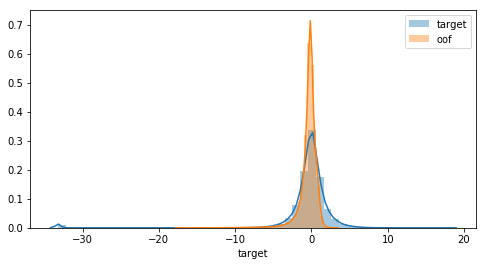

In [148]:
print('CV Score: {:.5f}'.format(mean_squared_error(train_df['target'], oof_df['target'])**0.5))

plt.figure(figsize=(8,4))

sns.distplot(train_df['target'], label='target')
sns.distplot(oof_df['target'], label='oof')

plt.legend()
plt.show()

外れ値に対するモデルの予測の分布  

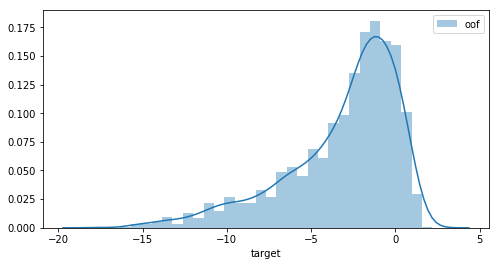

In [149]:
plt.figure(figsize=(8,4))

outliers_card_id = train_df.loc[train_df['outliers'] == 1, 'card_id']
sns.distplot(oof_df.loc[oof_df['card_id'].isin(outliers_card_id),'target'], label='oof')

plt.legend()
plt.show()

In [150]:
feature_importance_df = pd.read_csv('./inout/Private_LB_0609/output/feature_importance.csv')

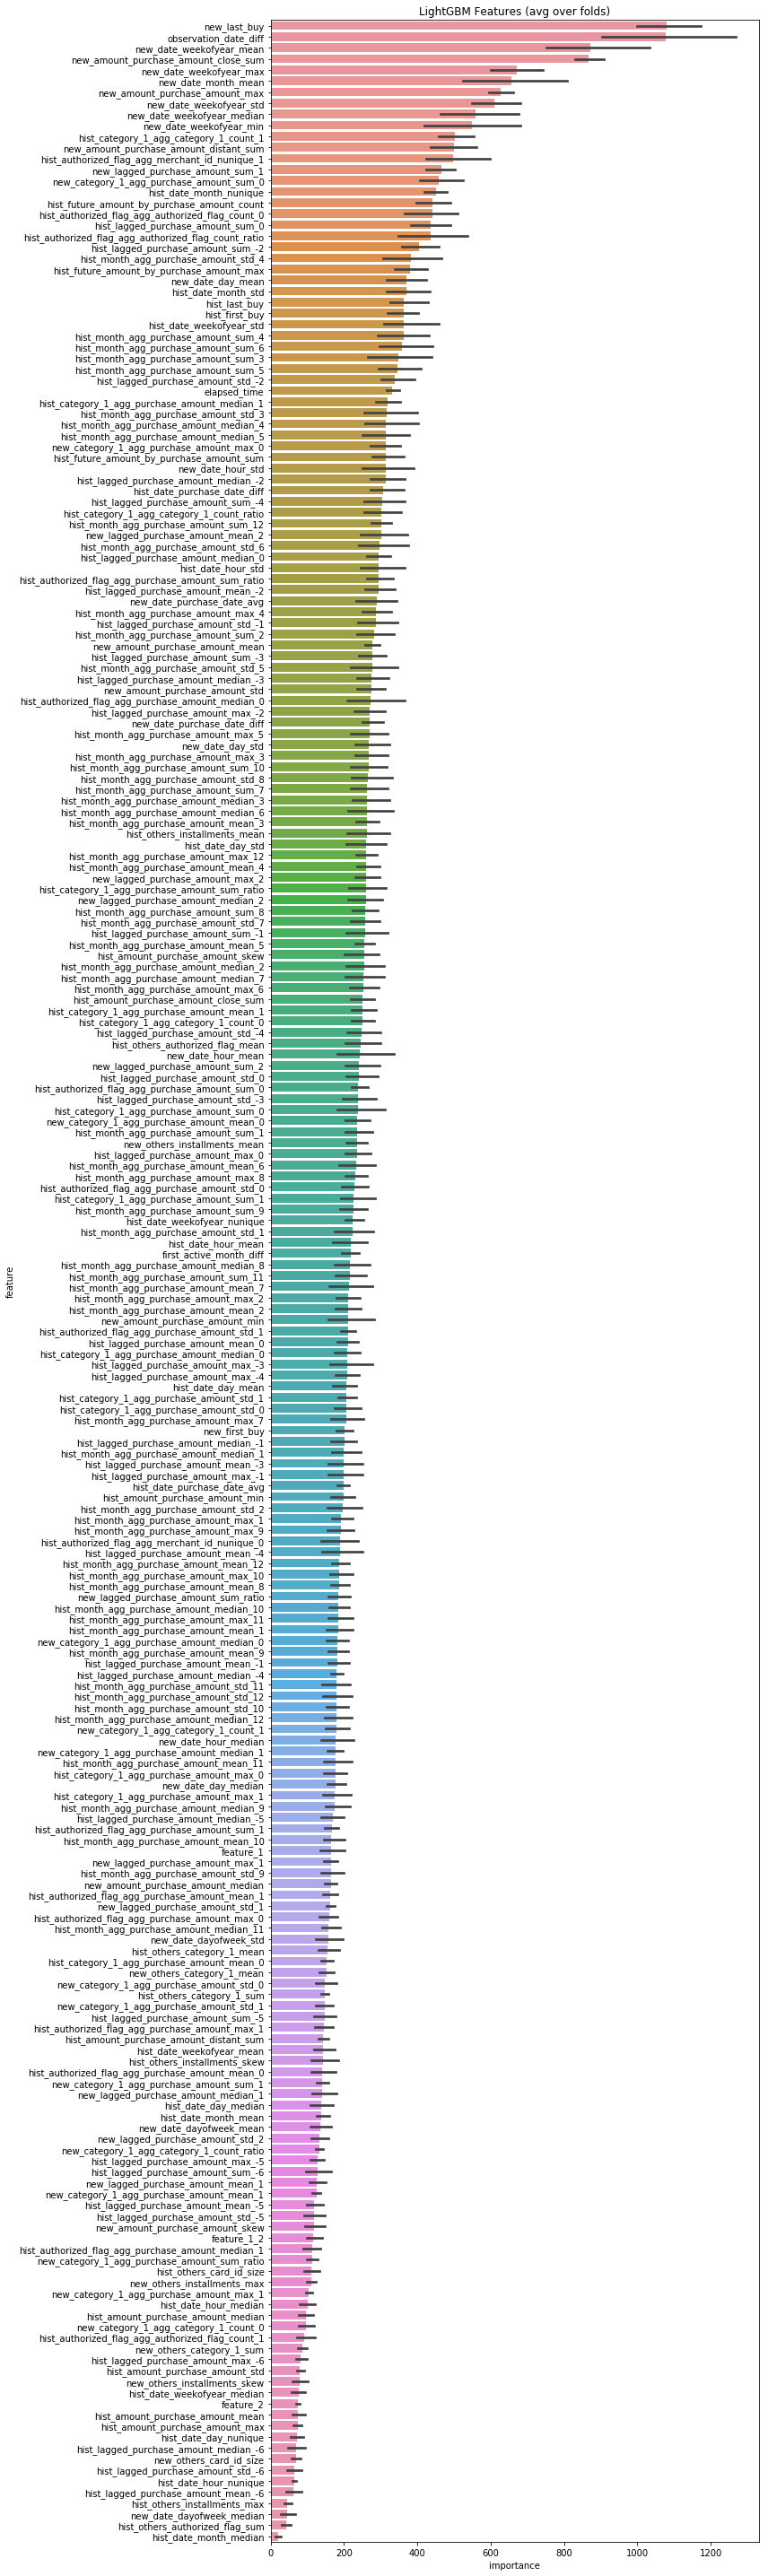

In [156]:
ordered_feature = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 40))

sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)

plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()